# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [0]:
from google.colab import drive
drive.mount('/content/drive')

### Change current working directory to project folder (1 mark)

In [46]:
import os
os.chdir("/Users/shast/FaceDetection")

### Load the "images.npy" file
- This file contains images with details of bounding boxes

In [47]:
import numpy as np
data = np.load('images.npy',allow_pickle=True)

### Check one sample from the loaded "images.npy" file

In [48]:
# Before checking the sample, we see the type of data
type(data)

numpy.ndarray

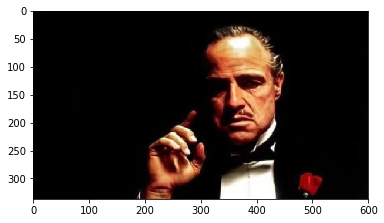

In [49]:
import matplotlib.pyplot as plt
plt.imshow(data[10][0])

### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [50]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [51]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (1 mark)

In [52]:
X_train.shape

(409, 224, 224, 3)

In [53]:
masks.shape

(409, 224, 224)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

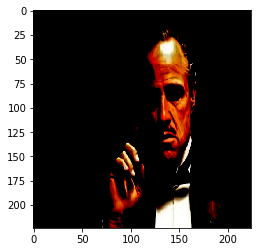

In [54]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

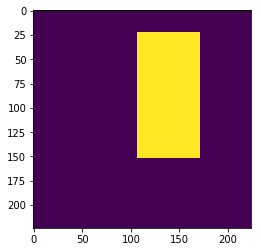

In [55]:
# we see that in the masked image the face is masked with label
pyplot.imshow(masks[n])

## Create the model
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [56]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model

# adding the mobilenet model and checking summary, before adding UNET layers

model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [ ]:
# from summary we can identify the layer names for UNET architecture which will total as 224*224:

# conv_pw_13_relu (None, 7, 7, 1024): final layer of Mobilenet, upsample has to be concatenated with the last downsample resulting in 14*14

# Similarly subsequent layers are identified:

# conv_pw_11_relu (None, 14, 14, 512)

# conv_pw_5_relu  (None, 28, 28, 256)

# conv_pw_3_relu  (None, 56, 56, 128)

# conv_pw_1_relu  (None, 112, 112, 64)  

In [57]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    layer1=model.get_layer("conv_pw_13_relu").output
    layer2=model.get_layer("conv_pw_11_relu").output
    layer3=model.get_layer("conv_pw_5_relu").output
    layer4=model.get_layer("conv_pw_3_relu").output
    layer5=model.get_layer("conv_pw_1_relu").output
        
    up_conv1 = UpSampling2D()(layer1)    
    out1=Concatenate()([up_conv1,layer2])
    
    up_conv2 = UpSampling2D()(out1)
    out2=Concatenate()([up_conv2,layer3])
    
    up_conv3 = UpSampling2D()(out2)
    out3=Concatenate()([up_conv3,layer4])
    
    up_conv4 = UpSampling2D()(out3)
    out4=Concatenate()([up_conv4,layer5])
    
    out=UpSampling2D()(out4)
    out=Conv2D(1,kernel_size=1,activation="sigmoid")(out)   
    out=Reshape((IMAGE_HEIGHT,IMAGE_WIDTH))(out)
    return Model(inputs=model.input,outputs=out)

### Call the create_model function

In [58]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalizationV1) (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

### Define dice coefficient function
- Create a function to calculate dice coefficient

In [59]:
# Dice coefficient is a metric to evaluate the model:
# Defined as (2*|x(intersection)y|)/|x|+|y|, where x=predicted set of pixels and y is the actual
# When there is a perfect overlap between x and y, a dice coefficient of 1 is achieved
import tensorflow as tf
def dice_coefficient(y_true, y_pred):
    numerator=2*tf.reduce_sum(y_true*y_pred)
    denominator=tf.reduce_sum(y_true+y_pred)
    dice_score=numerator/(denominator+tf.keras.backend.epsilon())
    return dice_score

### Define loss

In [60]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [61]:
model.compile('Adam',loss=loss,metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [62]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [63]:
model.fit(X_train,masks,epochs=2,verbose=1,batch_size=1,callbacks=[checkpoint,reduce_lr,stop])

Epoch 1/2
408/409 [============================>.] - ETA: 5s - loss: 1.2348 - dice_coefficient: 0.5085 
Epoch 00001: loss improved from inf to 1.23392, saving model to model-1.23.h5
409/409 [==============================] - 2192s 5s/sample - loss: 1.2339 - dice_coefficient: 0.5085
Epoch 2/2
408/409 [============================>.] - ETA: 5s - loss: 0.8387 - dice_coefficient: 0.6043 
Epoch 00002: loss improved from 1.23392 to 0.83865, saving model to model-0.84.h5
409/409 [==============================] - 2455s 6s/sample - loss: 0.8387 - dice_coefficient: 0.6040


### Get the predicted mask for a sample image

In [64]:
n = 10
sample_image = X_train[n]

mask=cv2.resize(1.0*(model.predict(x=np.array([sample_image]))[0]>0.5),(IMAGE_WIDTH,IMAGE_HEIGHT))

### Impose the mask on the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


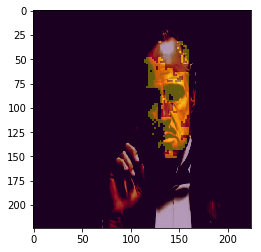

In [68]:
pyplot.imshow(sample_image)
pyplot.imshow(mask,alpha=0.4)

In [81]:
# trying with another image

sample_image = X_train[14]

mask=cv2.resize(1.0*(model.predict(x=np.array([sample_image]))[0]>0.5),(IMAGE_WIDTH,IMAGE_HEIGHT))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


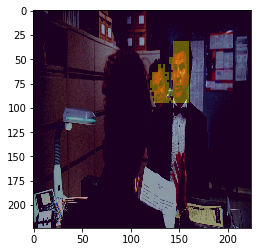

In [82]:
pyplot.imshow(sample_image)
pyplot.imshow(mask,alpha=0.4)